In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import a_funciones as fn 
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.model_selection import GridSearchCV, cross_validate


In [3]:
#Se vuelve a llamar la base de datos para la seleccion de variables
data = pd.read_csv("https://raw.githubusercontent.com/jsebastianzm/HR_T1_Analitica/main/data/data_preprocesamiento.csv")

In [4]:
#Es necesario volver a asignar las variables como variables object ya que al crearse el dataframe y volver
# a leerse con la libreria pandas, las variables vuelven a cambiar de tipo.
columns_category = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeID', 'Gender', 
'JobLevel', 'JobRole', 'MaritalStatus', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 
'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Attrition']
data[columns_category] = data[columns_category].astype(object)
data.drop(['EmployeeID'], axis = 1, inplace = True)

In [5]:
#Se asignan las variables object a variables dummies
dummies_variables = ["BusinessTravel", "Department", "Education", "EducationField", "Gender", "JobLevel", 
                     "Gender", "JobLevel", "JobRole", "MaritalStatus", "StockOptionLevel", "EnvironmentSatisfaction", 
                     "JobSatisfaction", "WorkLifeBalance", "JobInvolvement", "PerformanceRating"]
data_dummies = pd.get_dummies(data, columns=dummies_variables)

In [6]:
#Se separan las bases de datos en la variable a predecir y las variables independientes
y = data_dummies["Attrition"]
x = data_dummies.loc[:, ~data_dummies.columns.isin(['Attrition'])]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 75 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   DistanceFromHome                   4410 non-null   float64
 2   MonthlyIncome                      4410 non-null   float64
 3   NumCompaniesWorked                 4410 non-null   int64  
 4   PercentSalaryHike                  4410 non-null   int64  
 5   TotalWorkingYears                  4410 non-null   int64  
 6   TrainingTimesLastYear              4410 non-null   int64  
 7   YearsAtCompany                     4410 non-null   int64  
 8   YearsSinceLastPromotion            4410 non-null   int64  
 9   YearsWithCurrManager               4410 non-null   int64  
 10  BusinessTravel_Non-Travel          4410 non-null   uint8  
 11  BusinessTravel_Travel_Frequently   4410 non-null   uint8

In [7]:
#Se aplica labelencoder a la variables Y
encoder = LabelEncoder()

# Ajustar y transformar las categorías
y = encoder.fit_transform(y)
y = pd.DataFrame(y, columns = ['Attrition'])
y.head()



,Attrition
0,0
1,1
2,0
3,0
4,0


In [8]:
scaler=StandardScaler()
scaler.fit(x)
X2=scaler.transform(x)
X=pd.DataFrame(X2,columns=x.columns)


In [9]:
m_lreg = LogisticRegression()
m_rtree= tree.DecisionTreeClassifier()
m_rf= RandomForestClassifier()
m_gbt=GradientBoostingClassifier()

modelos=list([m_lreg,m_rtree, m_rf, m_gbt])
# modelos=list([m_lreg,m_rtree])



In [10]:
#
var_names_models=fn.sel_variables(modelos,X,y,threshold="1.7*mean")
var_names_models.shape


(18,)

In [11]:
#Se aplica seleccion de variables con el metodo Lasso
var_names_lasso=fn.sel_variablesLasso(modelos,X,y,alpha=0.03,max_features=15)
var_names_lasso.shape

(10,)

In [12]:
X_mod=X[var_names_models] ### matriz con variables seleccionadas
print(X_mod.shape, X.shape)

(4410, 18) (4410, 75)


In [13]:
X_Lasso=X[var_names_lasso] ### matriz con variables seleccionadas
print(X_Lasso.shape, X.shape)

(4410, 10) (4410, 75)


In [14]:
# X_mod.head()

In [15]:
#Medicion de los modelos para la clasificacion
F1_df=fn.medir_modelos(modelos,"f1",X,y,10) ## base con todas las variables 
F1_mod=fn.medir_modelos(modelos,"f1",X_mod,y,10) ### base con variables seleccionadas
F1_Lasso=fn.medir_modelos(modelos,"f1",X_Lasso,y,10) ### base con variables seleccionadas

In [16]:
F1_Lasso

,reg_logistic,decision_tree,random_forest,gradient_boosting
0,0.238095,0.934307,0.926471,0.446602
1,0.252874,0.964539,0.964539,0.524272
2,0.204545,0.957746,0.957746,0.369565
3,0.222222,0.958333,0.958333,0.375000
4,0.216867,0.948905,0.948905,0.514851
5,0.333333,0.950355,0.950355,0.475248
6,0.172840,0.959459,0.959459,0.307692
7,0.195122,0.948905,0.948905,0.408163
8,0.326087,0.935252,0.935252,0.538462
9,0.144578,0.965986,0.965986,0.361702


## Toca agregar y completar el boxplot siguiente

<Axes: >

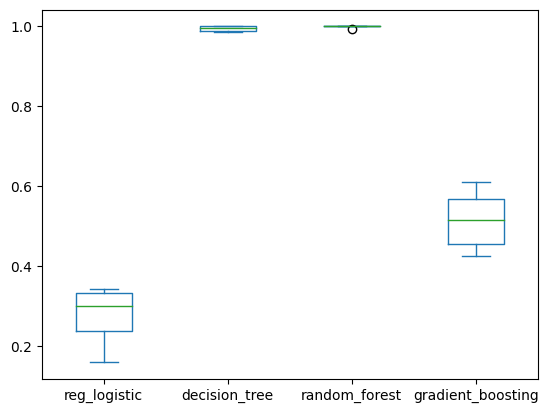

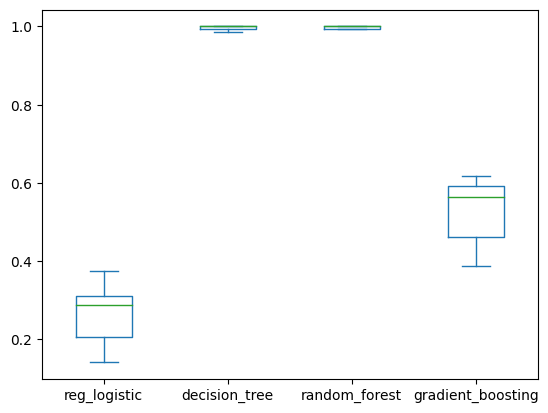

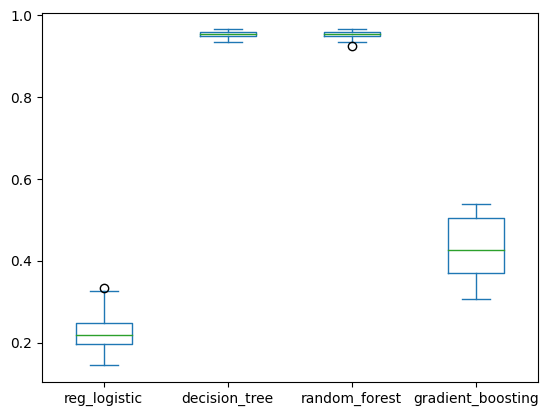

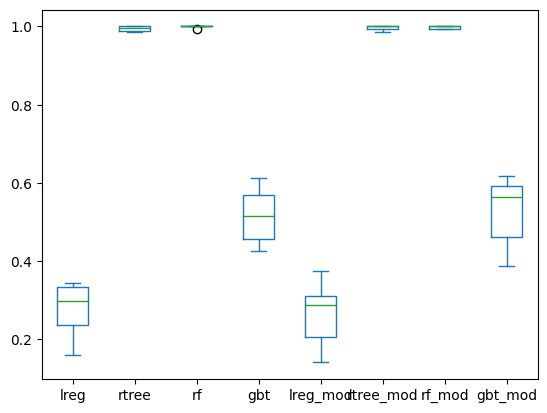

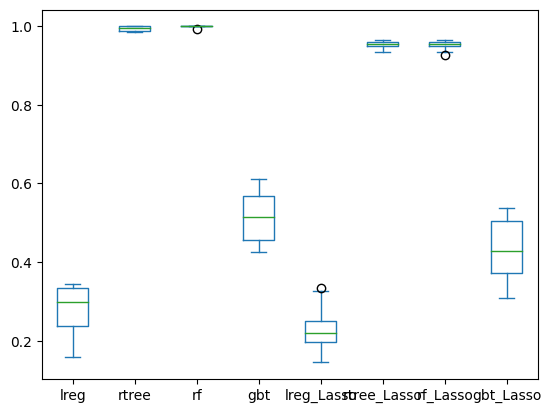

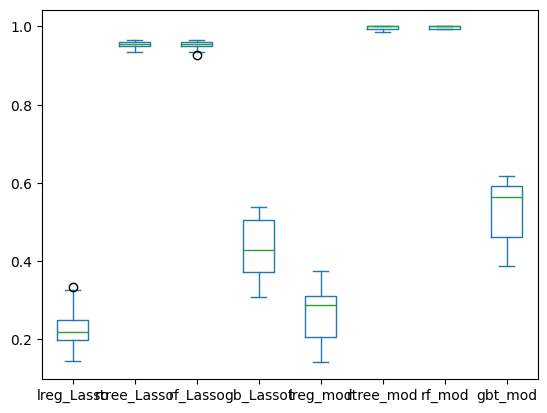

In [17]:
F1_score1 =pd.concat([F1_df,F1_mod],axis=1)
F1_score1.columns=['lreg', 'rtree', 'rf', 'gbt',
    'lreg_mod', 'rtree_mod', 'rf_mod', 'gbt_mod']

F1_score2 =pd.concat([F1_df,F1_Lasso],axis=1)
F1_score2.columns=['lreg', 'rtree', 'rf', 'gbt',
    'lreg_Lasso', 'rtree_Lasso', 'rf_Lasso', 'gbt_Lasso']

F1_score3 =pd.concat([F1_Lasso,F1_mod],axis=1)
F1_score3.columns=['lreg_Lasso', 'rtree_Lasso', 'rf_Lasso', 'gb_Lassot',
    'lreg_mod', 'rtree_mod', 'rf_mod', 'gbt_mod']

F1_df.plot(kind='box') #### gráfico para modelos todas las varibles
F1_mod.plot(kind='box') ### gráfico para modelo variables seleccionadas
F1_Lasso.plot(kind='box') ### gráfico para modelos sel y todas las variables
F1_score1.plot(kind='box')
F1_score2.plot(kind='box')
F1_score3.plot(kind='box')

In [18]:
F1_df.mean()

reg_logistic         0.283155
decision_tree        0.994345
random_forest        0.999291
gradient_boosting    0.515828
dtype: float64

In [19]:
F1_mod.mean()

reg_logistic         0.267014
decision_tree        0.995724
random_forest        0.997163
gradient_boosting    0.527498
dtype: float64

In [20]:
F1_Lasso.mean()

reg_logistic         0.230656
decision_tree        0.952379
random_forest        0.951595
gradient_boosting    0.432156
dtype: float64

In [39]:
param_grid = {'max_depth': [3,5,7,8,9],# Maxima profundidad
              'max_features': [0.7,0.8,0.9,1],# Maximo de caracteristicas a usar
              'max_leaf_nodes': [14,15,16,17,18],#Maximo de nodos
              'min_samples_leaf': [3,4,5,7,10,12],#Minimo de muestras para los nodos hoja
              'criterion': ['gini', 'entropy'],#Medir la cantidad de división.
              'splitter': ['best']}#Estrategia para dividir cada nodo

In [40]:
grid_search = GridSearchCV(m_rtree, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_mod, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 8, 9],
                         'max_features': [0.7, 0.8, 0.9, 1],
                         'max_leaf_nodes': [14, 15, 16, 17, 18],
                         'min_samples_leaf': [3, 4, 5, 7, 10, 12],
                         'splitter': ['best']},
             scoring='accuracy')

In [41]:
resultados = grid_search.cv_results_

In [42]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 0.8,
 'max_leaf_nodes': 18,
 'min_samples_leaf': 5,
 'splitter': 'best'}

In [43]:
pd.set_option('display.max_colwidth', 100)
pd_resultados = pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head()

,params,mean_test_score
416,"{'criterion': 'gini', 'max_depth': 8, 'max_features': 0.8, 'max_leaf_nodes': 18, 'min_samples_le...",0.866893
507,"{'criterion': 'gini', 'max_depth': 9, 'max_features': 0.7, 'max_leaf_nodes': 18, 'min_samples_le...",0.866667
538,"{'criterion': 'gini', 'max_depth': 9, 'max_features': 0.8, 'max_leaf_nodes': 18, 'min_samples_le...",0.865986
557,"{'criterion': 'gini', 'max_depth': 9, 'max_features': 0.9, 'max_leaf_nodes': 16, 'min_samples_le...",0.865986
327,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 0.9, 'max_leaf_nodes': 18, 'min_samples_le...",0.865533


In [26]:
# joblib.dump(grid_search, "decision_tree.pkl") ## Modelo escogido
# joblib.dump(columns_category, "list_cat.pkl") ### para realizar imputacion
# joblib.dump(dummies_variables, "list_dummies.pkl")  ### para convertir a dummies
# joblib.dump(f1_mod, "var_names.pkl")  ### para variables con que se entrena modelo
# joblib.dump(scaler, "scaler.pkl") ##

In [27]:
# rf_final = joblib.load("rf_final.pkl")
# m_lreg = joblib.load("m_lreg.pkl")
# list_cat=joblib.load("list_cat.pkl")
# list_dummies=joblib.load("list_dummies.pkl")
# var_names=joblib.load("var_names.pkl")
# scaler=joblib.load("scaler.pkl") 


In [28]:
#####Evaluar métrica de entrenamiento y evaluación para mirar sobre ajuste ####

# eval=cross_validate(rf_final,X2,y,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)

In [29]:
# # Separación en conjuntos de entrenamiento y validación con 80% de muestras para entrenamiento
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [30]:
# #Estandarización de variables númericas
# numeric_columns = data_dummies.loc[:, data_dummies.columns.isin(['Age', 'DistanceFromHome', 'EmployeeID', 
#                                 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
#                                 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'])]
# pipeline=ColumnTransformer([( "std_numericas",StandardScaler() , numeric_columns)], remainder='passthrough')

# x_train = pipeline.fit_transform(x_train)
# x_test = pipeline.transform(x_test)